In [1]:
%load_ext autoreload
%autoreload 2
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
# Setup device
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    # Check if MPS is available
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        # Fall back to CPU
        device = torch.device("cpu")

print("Device selected:", device)

Device selected: mps


In [2]:
## Get data
dataset = load_dataset("wikitext", name="wikitext-2-raw-v1")
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [3]:
splits = ['train', 'validation', 'test']
split = splits[0]
print(dataset[split][:5])

{'text': ['', ' = Valkyria Chronicles III = \n', '', ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n', " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game m

In [4]:
## Train a new tokenizer using Wiki dataset from GPT2 tokenizer
batch_size = 1000
vocab_size = 25000
chunk_size = 1024 # From GPT2

def batch_iterator():
    for split in splits:
        for i in range(0, len(dataset[split]), batch_size):
            yield dataset[split][i : i + batch_size]["text"]
# all_texts = [dataset[i : i + batch_size]["text"] for i in range(0, len(dataset), batch_size)]

gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(gpt2_tokenizer.is_fast)
tokenizer = gpt2_tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=25000)

True





In [5]:
tokenized_text = [tokenizer.tokenize(r) for r in dataset['train'][:5]["text"]]
print(tokenized_text)

[[], ['Ġ=', 'ĠValkyria', 'ĠChronicles', 'ĠIII', 'Ġ=', 'ĠĊ'], [], ['ĠSen', 'j', 'Åį', 'Ġno', 'ĠValkyria', 'Ġ3', 'Ġ:', 'ĠUn', 'rec', 'ord', 'ed', 'ĠChronicles', 'Ġ(', 'ĠJapanese', 'Ġ:', 'Ġæ', 'Ī', '¦', 'å', 'ł', '´', 'ãģ®', 'ãĥ', '´', 'ãĤ', '¡', 'ãĥ«', 'ãĤ', 'Ń', 'ãĥ', '¥', 'ãĥ', 'ªãĤ', '¢', '3', 'Ġ,', 'Ġlit', 'Ġ.', 'ĠValkyria', 'Ġof', 'Ġthe', 'ĠBattle', 'field', 'Ġ3', 'Ġ)', 'Ġ,', 'Ġcommonly', 'Ġreferred', 'Ġto', 'Ġas', 'ĠValkyria', 'ĠChronicles', 'ĠIII', 'Ġoutside', 'ĠJapan', 'Ġ,', 'Ġis', 'Ġa', 'Ġtactical', 'Ġrole', 'Ġ@-@', 'Ġplaying', 'Ġvideo', 'Ġgame', 'Ġdeveloped', 'Ġby', 'ĠSega', 'Ġand', 'ĠMedia', '.', 'V', 'ision', 'Ġfor', 'Ġthe', 'ĠPlayStation', 'ĠPortable', 'Ġ.', 'ĠReleased', 'Ġin', 'ĠJanuary', 'Ġ2011', 'Ġin', 'ĠJapan', 'Ġ,', 'Ġit', 'Ġis', 'Ġthe', 'Ġthird', 'Ġgame', 'Ġin', 'Ġthe', 'ĠValkyria', 'Ġseries', 'Ġ.', 'ĠEm', 'ploy', 'ing', 'Ġthe', 'Ġsame', 'Ġfusion', 'Ġof', 'Ġtactical', 'Ġand', 'Ġreal', 'Ġ@-@', 'Ġtime', 'Ġgameplay', 'Ġas', 'Ġits', 'Ġpredecessors', 'Ġ,', 'Ġthe', 'Ġstory',

In [6]:
## Preprocess the dataset
def preprocess_dataset(dataset, tokenizer, splits):
    encoded_dataset = {}
    
    for s in splits:
        dataset_string = ' '.join(dataset[s]['text'])
        tokenized_chunks = []
        chunk_size = 1024
        
        for i in range(0, len(dataset_string), chunk_size):
            chunk = dataset_string[i:i + chunk_size]
            encoded_chunk = tokenizer.encode(chunk)
            tokenized_chunks.append(encoded_chunk)
        
        # Combine tokenized chunks into a single tensor
        combined_chunks = [token for chunk in tokenized_chunks for token in chunk]
        encoded_dataset[s] = torch.tensor(combined_chunks, dtype=torch.long)
        
    return encoded_dataset


In [7]:
encoded_dataset = preprocess_dataset(dataset, tokenizer, splits)
print(encoded_dataset['train'][:20])
print(tokenizer.decode(encoded_dataset['train'][:20]))

tensor([  221,   301,  9823, 10724,  3252,   301,   315,   221,   221,  3707,
           74,  4163,   903,  9823,   487,   545,   665,  6904,   486,   267])
  = Valkyria Chronicles III = 
   Senjō no Valkyria 3 : Unrecorded


In [8]:
## Print tokens and text
from utils import get_batch
## Hyperparameters
block_size = 128
batch_size = 32
emb_dim = 64
num_layers = 4
num_heads = 16
dropout = 0.2
# x_toks, y_toks = get_batch(encoded_dataset['train'], device, block_size, batch_size)
# print(x_toks)
# print(y_toks)
# txt = [''.join(tokenizer.decode(t)) for t in x_toks.tolist()]
# for row in txt:
#     print(row)
#     print('================')

In [9]:
# Single test run
from models import Xformer_Scratch as Xformer
from torch.optim import Adam
import math
xb, yb =  get_batch(encoded_dataset['train'], device, block_size, batch_size)
model = Xformer(emb_dim, vocab_size, num_heads, num_layers, block_size, dropout).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
logits, loss = model(xb,yb)
xb.shape, yb.shape
print('Measured loss:', loss.item())
print('Expected loss:', -math.log(1./vocab_size))

Measured loss: 10.285148620605469
Expected loss: 10.126631103850338


In [10]:
from utils import get_model_size
get_model_size(model)

5024424

In [11]:
# Function to do a learning rate sweep
def get_lr_loss(model, optimizer, dataset, num_epochs, device, lr_start_exp=-3, lr_end_exp=0.5):

    lrexp = torch.linspace(lr_start_exp, lr_end_exp, num_epochs, requires_grad=False)
    lrs_val = 10**lrexp

    lri = []
    lossi = []
    # Training loop with mini-batches and lr sweep
    for epoch in range(num_epochs):

        ## Set learning rate
        for g in optimizer.param_groups:
            g['lr'] = lrs_val[epoch]

        xb, yb = get_batch(dataset, device, block_size, batch_size)


        # Forward pass
        _, loss = model(xb, yb)
        lri.append(lrs_val[epoch])
        lossi.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return lri, lossi

Text(0, 0.5, 'Loss')

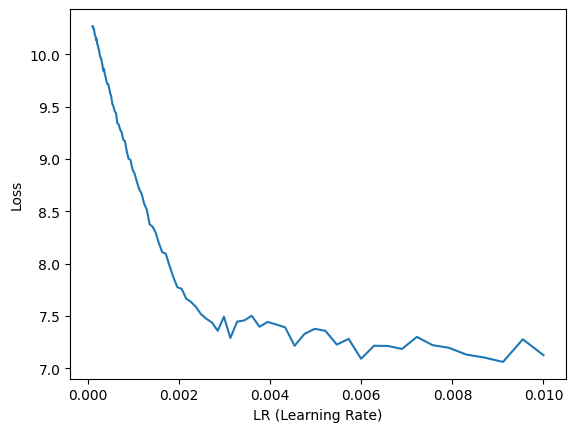

In [12]:
# # ## Optimal lr sweep
# from utils import get_lr_loss
import matplotlib.pyplot as plt
num_epochs = 100
lri, lossi =  get_lr_loss(model, optimizer, encoded_dataset['train'], num_epochs, device, -4, -2)
plt.plot(lri, lossi)
# Add labels to the x-axis and y-axis
plt.xlabel('LR (Learning Rate)')
plt.ylabel('Loss')


In [13]:
## Initialize loss matrices and batch size
tr_loss = []
val_loss = []
tr_loss_raw = []
batch_size = 32

In [14]:
from utils import evaluate_loss
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

## Initialize training parameters
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

# Define the parameters for the scheduler
warmup_epochs = 5
n_epochs = 100  # Adjust this according to your training duration
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=n_epochs - warmup_epochs, T_mult=1, eta_min=0)

for epoch in range(n_epochs):
    # Adjust learning rate using scheduler
    scheduler.step(epoch)
    
    # for param_group in optimizer.param_groups:
    #     print("Learning rate:", param_group['lr'])

    xtr, ytr = get_batch(encoded_dataset['train'], device, block_size, batch_size)
    xval, yval = get_batch(encoded_dataset['validation'], device, block_size, batch_size)
    eval_dataset = {'train': (xtr,ytr), 'validation': (xval, yval)}
    logits, loss = model(xtr,ytr)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, val_lossi = evaluate_loss(model, eval_dataset, num_batches=16)
    tr_loss.append(tr_lossi)
    val_loss.append(val_lossi)
    tr_loss_raw.append(loss.item())

    ## Print losses
    if epoch % 10 == 0:
        print(epoch, ' --> train loss: ', tr_lossi, 'validation loss: ', val_lossi, 'single shot loss:', loss.item())

Learning rate: 0.001
0  --> train loss:  7.071613311767578 validation loss:  7.1481547355651855 single shot loss: 7.145566463470459
Learning rate: 0.000999726628670463
Learning rate: 0.0009989068136093873
Learning rate: 0.0009975414512725057
Learning rate: 0.0009956320346634876
Learning rate: 0.0009931806517013613
Learning rate: 0.0009901899829374047
Learning rate: 0.000986663298624003
Learning rate: 0.0009826044551386743
Learning rate: 0.0009780178907671788
Learning rate: 0.0009729086208503173
10  --> train loss:  7.170460224151611 validation loss:  7.196144104003906 single shot loss: 7.211848258972168
Learning rate: 0.0009672822322997304
Learning rate: 0.0009611448774886924
Learning rate: 0.0009545032675245813
Learning rate: 0.0009473646649103818
Learning rate: 0.0009397368756032445
Learning rate: 0.0009316282404787869
Learning rate: 0.0009230476262104677
Learning rate: 0.00091400441557401
Learning rate: 0.0009045084971874737
Learning rate: 0.0008945702546981969
20  --> train loss:  

In [ ]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss)
plt.plot(val_loss)

print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(val_loss[-100:]))).item(),4))

In [ ]:
from torch.nn import functional as F
@torch.no_grad()
def generate(model, idx, max_new_tokens, device, block_size=16):
    """Generates a single batch of names based on since of idx matrix. Accessed via print_samples"""
    for _ in range(max_new_tokens):
        # print('idx shape:',idx.shape)
        # print(idx)
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        idx_cond = idx_cond.to(device)
        logits, _ = model(idx_cond)
        # Pick only the logits from most recent time step. Karpathy also does a divide by temp?
        # This is just Platt scaling which makes the various Softmax curves closes adding more randomness
        # see scratch.ipynb. https://en.wikipedia.org/wiki/Platt_scaling
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        # print('prob dist:',probs)
        idx_next = torch.multinomial(probs, num_samples=1)
        # print('idx_next shape:',idx_next.shape)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
def print_samples(model, tokenizer, seed_text, max_new_tokens, device):
    """ samples from the model and pretty prints the decoded samples """
    # X_init = torch.zeros((num, 1), dtype=torch.long).to(device)
    seed_tokens = torch.tensor(tokenizer.encode(seed_text), dtype=torch.long).to(device)
    seed_tokens = seed_tokens[None, ...]
    X_samp = generate(model, seed_tokens, max_new_tokens, device)[:,1:].tolist()
    # print(X_samp)
    # # print(X_samp)
    for row in X_samp:
        crop_index = row.index(0) if 0 in row else len(row)
        # print(row, crop_index)
        row = row[:crop_index]
        print(tokenizer.decode(row))

In [ ]:
## Generate samples
# from utils import print_samples
print_samples(model, tokenizer, 'In the dark ages', 128, device)

In [ ]:
# Specify the file path where you want to save the model weights
file_path = 'model_weights.pt'

# Save the model weights
torch.save(model.state_dict(), file_path)

In [ ]:
import torch
model = Xformer(emb_dim, vocab_size, num_heads, num_layers, block_size, dropout).to(device)
# Load the saved model weights
file_path = 'wiki-2.pt'
model.load_state_dict(torch.load(file_path))
print_samples(model, tokenizer, 'In the dark ages', 128, device)